# Guillaume Payeur (260929164)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
plt.rcParams.update({"text.usetex": True})

# Q1

## a)

Begin by loading and plotting the raw data

In [2]:
# Loading data
stuff=np.load('mcmc/sidebands.npz')
t=stuff['time'][::100]
d=stuff['signal'][::100]

Text(0, 0.5, 'signal')

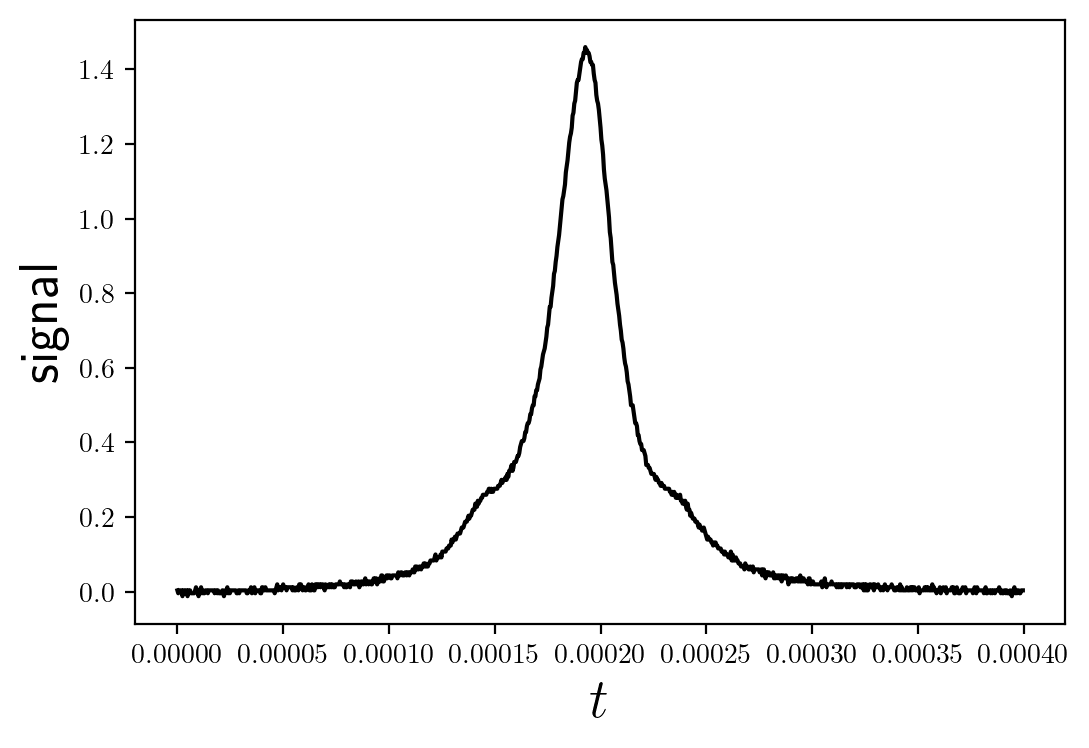

In [3]:
plt.plot(t,d,color='black')
plt.xlabel('$t$',fontsize=20)
plt.ylabel('signal',fontsize=20)

Fit the amplitude $a$, width $w$ and center $t_0$ of the Lorentzian using Newton's method with initial guess $a=1.4$,$w=0.0001$,$t_0=0.0002$.

In [4]:
# Initial guess for parameters
a = 1.4
w = 0.0001
t0 = 0.0002
m = np.array([a,w,t0])

# Doing 20 itterations of Newton's method
for i in range(20):
    # Computing residuals
    Am = m[0]/(1+((t-m[2])**2)/(m[1]**2))
    r = d-Am

    # Computing gradient of A
    A_a = 1/(1+((t-m[2])**2)/(m[1]**2))
    A_w = (2*m[0]*(t-m[2])**2)/((m[1]**3)*((1+((t-m[2])**2)/(m[1]**2)))**2)
    A_t0 = (2*m[0]*(t-m[2]))/((m[1]**2)*(1+((t-m[2])**2/(m[1])**2))**2)
    A_m = np.zeros((A_a.shape[0],3))
    A_m[:,0] = A_a
    A_m[:,1] = A_w
    A_m[:,2] = A_t0
               
    # Computing delta m
    delta_m = np.linalg.inv(A_m.T@A_m)@A_m.T@r
    m = m + delta_m
    
# Printing best fit parameters
print(m)

[1.42385677e+00 1.78990366e-05 1.92363906e-04]


Making a plot of the data and the fit to make sure it worked

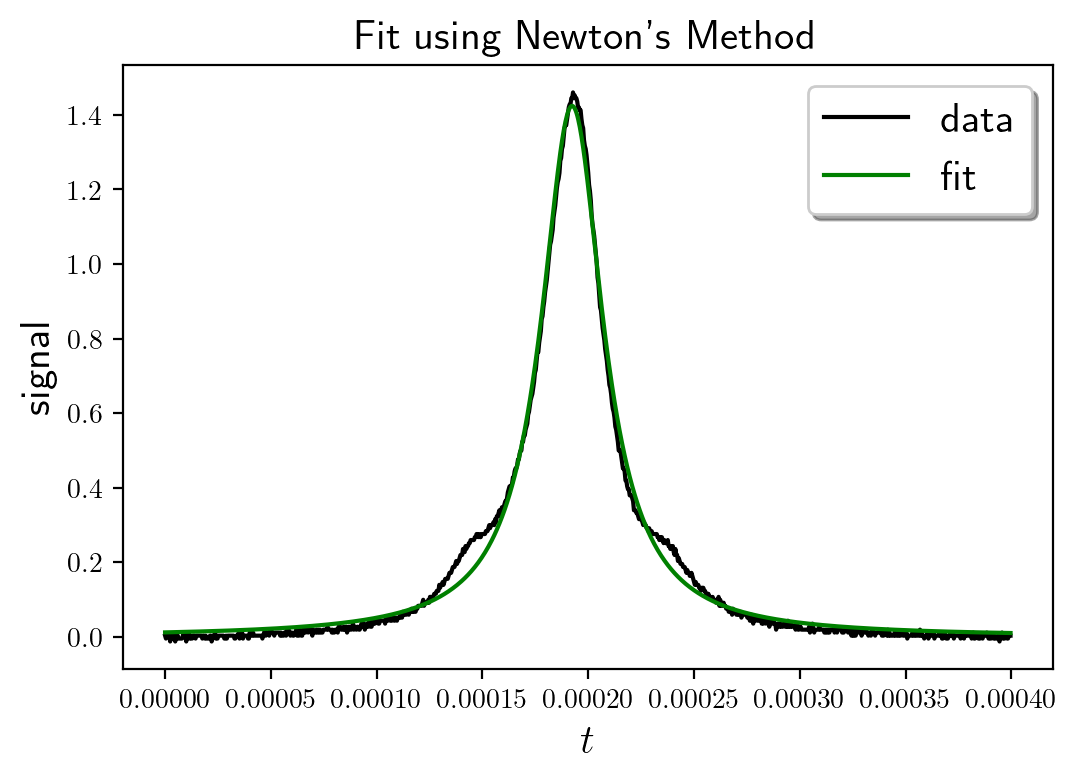

In [5]:
plt.plot(t,d,color='black',label='data')
plt.plot(t,m[0]/(1+((t-m[2])**2)/(m[1]**2)),color='green',label='fit')
plt.xlabel('$t$',fontsize=15)
plt.ylabel('signal',fontsize=15)
plt.title("Fit using Newton's Method",fontsize=15)
plt.legend(loc=0,frameon=True,shadow=True,fontsize=15)

The fit looks reasonably good. The parameters we got are
\begin{align}
    a &= 1.42\\
    w &= 1.79\text{x}10^{-5}\\
    t_0 &= 1.92\text{x}10^{-4}
\end{align}

## b)

Assume the standard error on each data point is 0.005. Then we can find the uncertainty on the model parameters

In [6]:
# Initial parameters
a = 1.4
w = 0.0001
t0 = 0.0002
m = np.array([a,w,t0])

# Doing 20 itterations of Newton's method
for i in range(20):
    # Computing residuals
    Am = m[0]/(1+((t-m[2])**2)/(m[1]**2))
    r = d-Am

    # Computing gradient of A
    A_a = 1/(1+((t-m[2])**2)/(m[1]**2))
    A_w = (2*m[0]*(t-m[2])**2)/((m[1]**3)*((1+((t-m[2])**2)/(m[1]**2)))**2)
    A_t0 = (2*m[0]*(t-m[2]))/((m[1]**2)*(1+((t-m[2])**2/(m[1])**2))**2)
    A_m = np.zeros((A_a.shape[0],3))
    A_m[:,0] = A_a
    A_m[:,1] = A_w
    A_m[:,2] = A_t0
               
    # Computing delta m
    delta_m = np.linalg.inv(A_m.T@A_m)@A_m.T@r
    m = m + delta_m
    
# Calculating uncertainty on best fit parameters
sigma = 0.005
Ninv = np.eye(t.shape[0])/(sigma**2)
cov = np.linalg.inv(A_m.T@Ninv@A_m)
    
# Printing uncertainty on best fit parameters
print(np.sqrt(np.diag(cov)))

[8.43664905e-04 1.50143192e-08 1.06024471e-08]


So the fit parameters with uncertainty are
\begin{align}
    a &= 1.42 \pm 8.44\text{x}10^{-4}\\
    w &= 1.79\text{x}10^{-5} \pm 1.50\text{x}10^{-8}\\
    t_0 &= 1.92\text{x}10^{-4} \pm 1.06\text{x}10^{-8}
\end{align}
But note that we shouldn't trust these parameters or these errors since the model is not a good fit to the data: clearly the residuals are correlated.

## c)

We redo part a) with numerical derivatives.

In [7]:
# Function to take numerical derivative of fun at x
def ndiff(fun,x):
    # machine precision
    eps = 1e-16
    delta = np.sqrt(eps)
    
    # Calculating derivative
    deriv = 1/(2*delta)*(fun(x+delta)-fun(x-delta))
    return deriv

# Initial guess for parameters
a = 1.4
w = 0.0001
t0 = 0.0002
m = np.array([a,w,t0])

# Doing 20 itterations of Newton's method
for i in range(20):
    # Computing residuals
    Am = m[0]/(1+((t-m[2])**2)/(m[1]**2))
    r = d-Am

    # Computing gradient of A numerically
    def fun_a(a):
        return a/(1+((t-m[2])**2)/(m[1]**2))
    A_a = ndiff(fun_a,m[0])
    def fun_w(w):
        return m[0]/(1+((t-m[2])**2)/(w**2))
    A_w = ndiff(fun_w,m[1])
    def fun_t0(t0):
        return m[0]/(1+((t-t0)**2)/(m[1]**2))
    A_t0 = ndiff(fun_t0,m[2])
    
    A_m = np.zeros((A_a.shape[0],3))
    A_m[:,0] = A_a
    A_m[:,1] = A_w
    A_m[:,2] = A_t0
               
    # Computing delta m
    delta_m = np.linalg.inv(A_m.T@A_m)@A_m.T@r
    m = m + delta_m
    
# Printing best fit parameters
print(m)

[1.42385678e+00 1.78990366e-05 1.92363906e-04]


The parameters we got now are
\begin{align}
    a &= 1.42\\
    w &= 1.79\text{x}10^{-5}\\
    t_0 &= 1.92\text{x}10^{-4}
\end{align}
and the difference between them and the parameters we got before is less than 1 time the standard error on the parameters determined before, so the difference is not statistically significant. Both ways of proceeding worked equally well.

## d) 

We repeat part c) but with three Lorentzians

In [8]:
# Function to take numerical derivative of fun at x
def ndiff(fun,x):
    # machine precision
    eps = 1e-16
    delta = np.sqrt(eps)
    
    # Calculating derivative
    deriv = 1/(2*delta)*(fun(x+delta)-fun(x-delta))
    return deriv

# Initial guess for parameters
a = 1.42
b = 0.1
c = 0.1
w = 0.000018
t0 = 0.000192
dx = 0.00004
m = np.array([a,b,c,w,t0,dx])

# Doing 20 itterations of Newton's method
for i in range(20):
    # Computing residuals
    Am = m[0]/(1+((t-m[4])**2)/(m[3]**2)) + m[1]/(1+((t-m[4]+m[5])**2)/(m[3]**2)) + m[2]/(1+((t-m[4]-m[5])**2)/(m[3]**2))
    r = d-Am

    # Computing gradient of A numerically
    def fun_a(a):
        return a/(1+((t-m[4])**2)/(m[3]**2)) + m[1]/(1+((t-m[4]+m[5])**2)/(m[3]**2)) + m[2]/(1+((t-m[4]-m[5])**2)/(m[3]**2))
    A_a = ndiff(fun_a,m[0])
    def fun_b(b):
        return m[0]/(1+((t-m[4])**2)/(m[3]**2)) + b/(1+((t-m[4]+m[5])**2)/(m[3]**2)) + m[2]/(1+((t-m[4]-m[5])**2)/(m[3]**2))
    A_b = ndiff(fun_b,m[1])
    def fun_c(c):
        return m[0]/(1+((t-m[4])**2)/(m[3]**2)) + m[1]/(1+((t-m[4]+m[5])**2)/(m[3]**2)) + c/(1+((t-m[4]-m[5])**2)/(m[3]**2))
    A_c = ndiff(fun_c,m[2])
    def fun_w(w):
        return m[0]/(1+((t-m[4])**2)/(w**2)) + m[1]/(1+((t-m[4]+m[5])**2)/(w**2)) + m[2]/(1+((t-m[4]-m[5])**2)/(w**2))
    A_w = ndiff(fun_w,m[3])
    def fun_t0(t0):
        return m[0]/(1+((t-t0)**2)/(m[3]**2)) + m[1]/(1+((t-t0+m[5])**2)/(m[3]**2)) + m[2]/(1+((t-t0-m[5])**2)/(m[3]**2))
    A_t0 = ndiff(fun_t0,m[4])
    def fun_dx(dx):
        return m[0]/(1+((t-m[4])**2)/(m[3]**2)) + m[1]/(1+((t-m[4]+dx)**2)/(m[3]**2)) + m[2]/(1+((t-m[4]-dx)**2)/(m[3]**2))
    A_dx = ndiff(fun_dx,m[5])
    
    A_m = np.zeros((A_a.shape[0],6))
    A_m[:,0] = A_a
    A_m[:,1] = A_b
    A_m[:,2] = A_c
    A_m[:,3] = A_w
    A_m[:,4] = A_t0
    A_m[:,5] = A_dx
               
    # Computing delta m
    delta_m = np.linalg.inv(A_m.T@A_m)@A_m.T@r
    m = m + delta_m
    
# Printing best fit parameters
print(m)

[1.44403041e+00 1.03678060e-01 6.44510546e-02 1.60517917e-05
 1.92581549e-04 4.46179190e-05]


Plotting the fit to make sure it worked

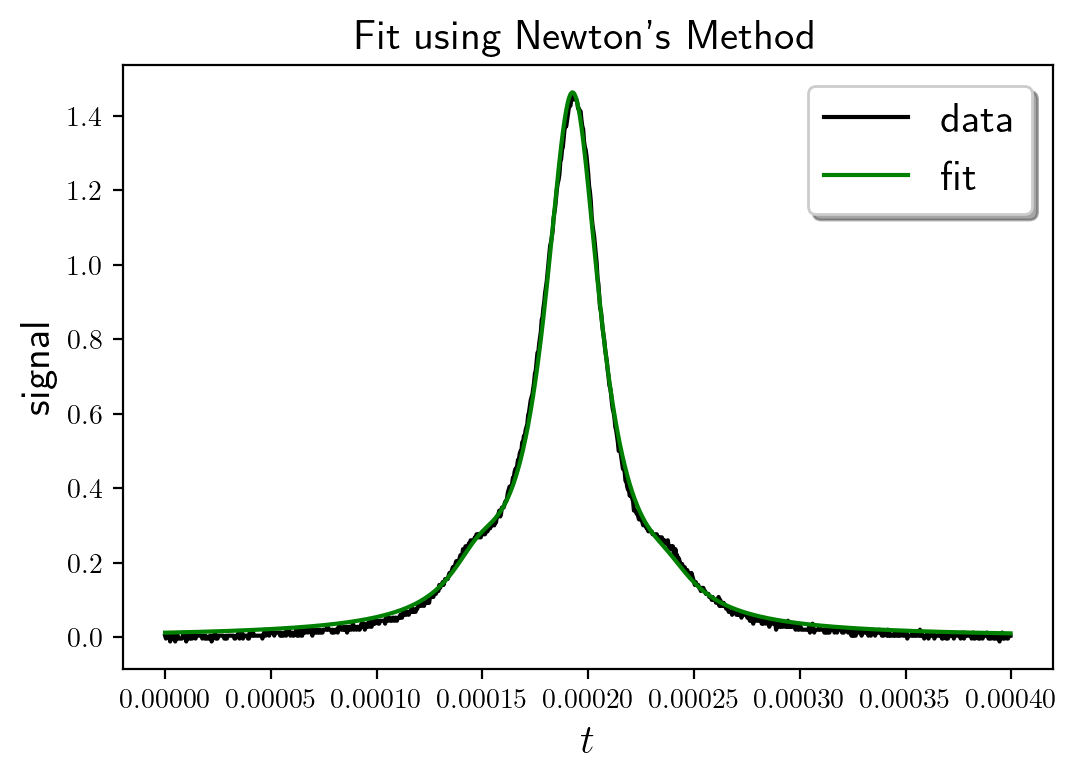

In [9]:
plt.plot(t,d,color='black',label='data')
plt.plot(t,m[0]/(1+((t-m[4])**2)/(m[3]**2)) + m[1]/(1+((t-m[4]+m[5])**2)/(m[3]**2)) + m[2]/(1+((t-m[4]-m[5])**2)/(m[3]**2)),color='green',label='fit')
plt.xlabel('$t$',fontsize=15)
plt.ylabel('signal',fontsize=15)
plt.title("Fit using Newton's Method",fontsize=15)
plt.legend(loc=0,frameon=True,shadow=True,fontsize=15)

The fit looks better than before. The parameters we got are
\begin{align}
    a &= 1.44\\
    b &= 1.04\text{x}10^{-1}\\
    c &= 6.45\text{x}10^{-2}\\
    w &= 1.61\text{x}10^{-5}\\
    t_0 &= 1.93\text{x}10^{-4}\\
    dx &= 4.46\text{x}10^{-5}
\end{align}

Now we find the uncertainties as we did before

In [10]:
# Function to take numerical derivative of fun at x
def ndiff(fun,x):
    # machine precision
    eps = 1e-16
    delta = np.sqrt(eps)
    
    # Calculating derivative
    deriv = 1/(2*delta)*(fun(x+delta)-fun(x-delta))
    return deriv

# Initial guess for parameters
a = 1.42
b = 0.1
c = 0.1
w = 0.000018
t0 = 0.000192
dx = 0.00004
m = np.array([a,b,c,w,t0,dx])

# Doing 20 itterations of Newton's method
for i in range(20):
    # Computing residuals
    Am = m[0]/(1+((t-m[4])**2)/(m[3]**2)) + m[1]/(1+((t-m[4]+m[5])**2)/(m[3]**2)) + m[2]/(1+((t-m[4]-m[5])**2)/(m[3]**2))
    r = d-Am

    # Computing gradient of A numerically
    def fun_a(a):
        return a/(1+((t-m[4])**2)/(m[3]**2)) + m[1]/(1+((t-m[4]+m[5])**2)/(m[3]**2)) + m[2]/(1+((t-m[4]-m[5])**2)/(m[3]**2))
    A_a = ndiff(fun_a,m[0])
    def fun_b(b):
        return m[0]/(1+((t-m[4])**2)/(m[3]**2)) + b/(1+((t-m[4]+m[5])**2)/(m[3]**2)) + m[2]/(1+((t-m[4]-m[5])**2)/(m[3]**2))
    A_b = ndiff(fun_b,m[1])
    def fun_c(c):
        return m[0]/(1+((t-m[4])**2)/(m[3]**2)) + m[1]/(1+((t-m[4]+m[5])**2)/(m[3]**2)) + c/(1+((t-m[4]-m[5])**2)/(m[3]**2))
    A_c = ndiff(fun_c,m[2])
    def fun_w(w):
        return m[0]/(1+((t-m[4])**2)/(w**2)) + m[1]/(1+((t-m[4]+m[5])**2)/(w**2)) + m[2]/(1+((t-m[4]-m[5])**2)/(w**2))
    A_w = ndiff(fun_w,m[3])
    def fun_t0(t0):
        return m[0]/(1+((t-t0)**2)/(m[3]**2)) + m[1]/(1+((t-t0+m[5])**2)/(m[3]**2)) + m[2]/(1+((t-t0-m[5])**2)/(m[3]**2))
    A_t0 = ndiff(fun_t0,m[4])
    def fun_dx(dx):
        return m[0]/(1+((t-m[4])**2)/(m[3]**2)) + m[1]/(1+((t-m[4]+dx)**2)/(m[3]**2)) + m[2]/(1+((t-m[4]-dx)**2)/(m[3]**2))
    A_dx = ndiff(fun_dx,m[5])
    
    A_m = np.zeros((A_a.shape[0],6))
    A_m[:,0] = A_a
    A_m[:,1] = A_b
    A_m[:,2] = A_c
    A_m[:,3] = A_w
    A_m[:,4] = A_t0
    A_m[:,5] = A_dx
               
    # Computing delta m
    delta_m = np.linalg.inv(A_m.T@A_m)@A_m.T@r
    m = m + delta_m
    
# Calculating uncertainty on best fit parameters
Ninv = np.eye(t.shape[0])/(sigma**2)
cov = np.linalg.inv(A_m.T@Ninv@A_m)
    
# Printing uncertainty on best fit parameters
print(np.sqrt(np.diag(cov)))

[9.14128147e-04 8.70429036e-04 8.52345103e-04 1.93273356e-08
 1.08008106e-08 1.30674361e-07]


So the fit parameters with uncertainty are
\begin{align}
    a &= 1.44 \pm 9.14\text{x}10^{-4}\\
    b &= 1.04\text{x}10^{-1} \pm 8.70\text{x}10^{-4}\\
    c &= 6.45\text{x}10^{-2} \pm 8.52\text{x}10^{-4}\\
    w &= 1.61\text{x}10^{-5} \pm 1.93\text{x}10^{-8}\\
    t_0 &= 1.93\text{x}10^{-4} \pm 1.08\text{x}10^{-8}\\
    dx &= 4.46\text{x}10^{-5} \pm 1.31\text{x}10^{-7}
\end{align}

# e)

Now we plot the residuals.

Text(0.5, 1.0, 'Fit residuals')

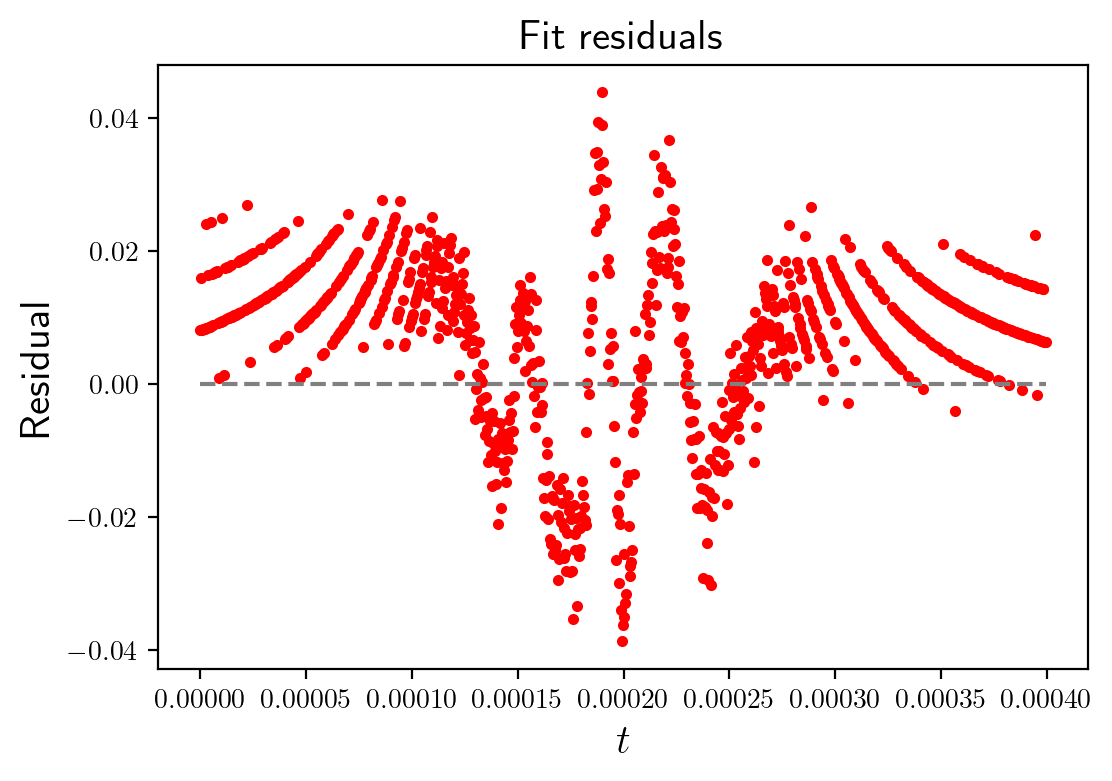

In [11]:
plt.plot(t,m[0]/(1+((t-m[4])**2)/(m[3]**2)) + m[1]/(1+((t-m[4]+m[5])**2)/(m[3]**2)) + m[2]/(1+((t-m[4]-m[5])**2)/(m[3]**2))-d,color='red',lw=0,marker='.')
plt.plot(t,t*0,color='gray',ls='--')
plt.xlabel('$t$',fontsize=15)
plt.ylabel('Residual',fontsize=15)
plt.title("Fit residuals",fontsize=15)

The residuals are clearly correlated, so no, the error bars I got by assuming the data are independent with uniform variance are not a complete description of the data.

# f)

We generate realisations for the parameter errors using Cholesky decomposition. Here I plot three realisations on top of each other

In [12]:
L = np.linalg.cholesky(cov)
n1 = L@np.random.randn(6)
n2 = L@np.random.randn(6)
n3 = L@np.random.randn(6) 
m1 = m+n1
m2 = m+n2
m3 = m+n3

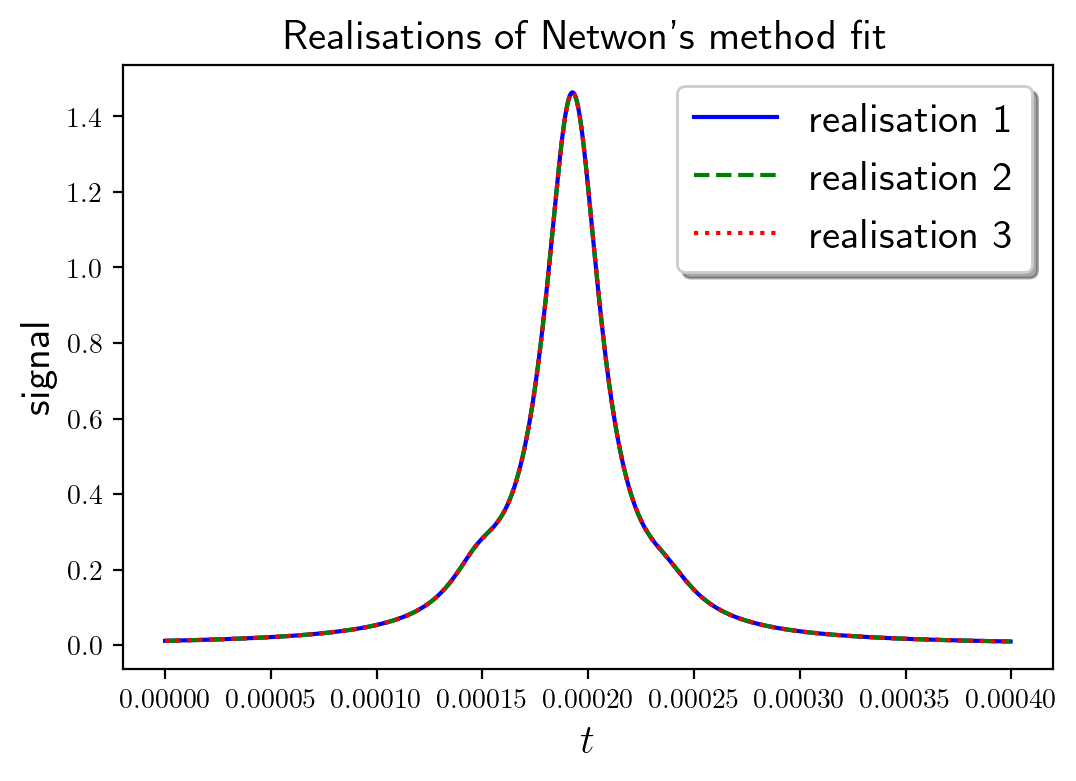

In [13]:
plt.plot(t,m1[0]/(1+((t-m1[4])**2)/(m1[3]**2)) + m1[1]/(1+((t-m1[4]+m1[5])**2)/(m1[3]**2)) + m1[2]/(1+((t-m1[4]-m1[5])**2)/(m1[3]**2)),color='blue',label='realisation 1')
plt.plot(t,m2[0]/(1+((t-m2[4])**2)/(m2[3]**2)) + m2[1]/(1+((t-m2[4]+m2[5])**2)/(m2[3]**2)) + m2[2]/(1+((t-m2[4]-m2[5])**2)/(m2[3]**2)),color='green',ls='--',label='realisation 2')
plt.plot(t,m3[0]/(1+((t-m3[4])**2)/(m3[3]**2)) + m3[1]/(1+((t-m3[4]+m3[5])**2)/(m3[3]**2)) + m3[2]/(1+((t-m3[4]-m3[5])**2)/(m3[3]**2)),color='red',ls=':',label='realisation 3')
plt.xlabel('$t$',fontsize=15)
plt.ylabel('signal',fontsize=15)
plt.title("Realisations of Netwon's method fit",fontsize=15)
plt.legend(loc=0,frameon=True,shadow=True,fontsize=15)

We can't really see the difference, but here's the residuals (with respect to the best fit model)

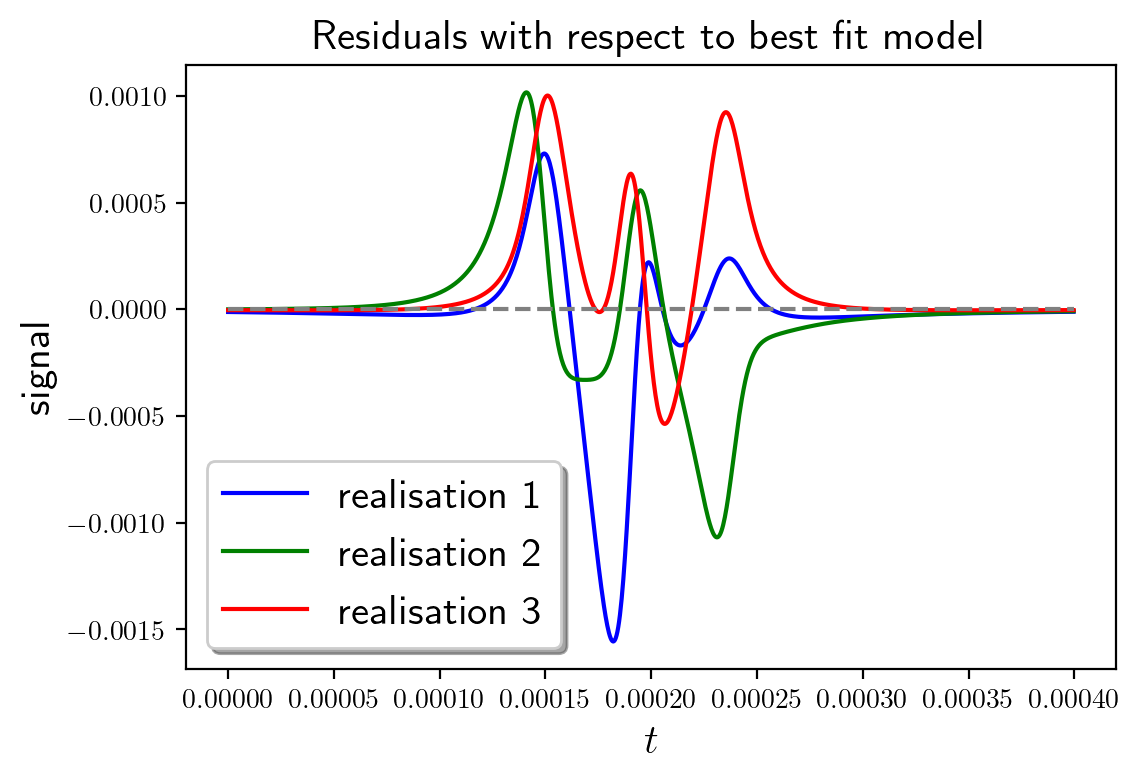

In [14]:
d_best_fit = m[0]/(1+((t-m[4])**2)/(m[3]**2)) + m[1]/(1+((t-m[4]+m[5])**2)/(m[3]**2)) + m[2]/(1+((t-m[4]-m[5])**2)/(m[3]**2)) 
d_1 = m1[0]/(1+((t-m1[4])**2)/(m1[3]**2)) + m1[1]/(1+((t-m1[4]+m1[5])**2)/(m1[3]**2)) + m1[2]/(1+((t-m1[4]-m1[5])**2)/(m1[3]**2))
d_2 = m2[0]/(1+((t-m2[4])**2)/(m2[3]**2)) + m2[1]/(1+((t-m2[4]+m2[5])**2)/(m2[3]**2)) + m2[2]/(1+((t-m2[4]-m2[5])**2)/(m2[3]**2))
d_3 = m3[0]/(1+((t-m3[4])**2)/(m3[3]**2)) + m3[1]/(1+((t-m3[4]+m3[5])**2)/(m3[3]**2)) + m3[2]/(1+((t-m3[4]-m3[5])**2)/(m3[3]**2))

plt.plot(t,d_best_fit-d_1,color='blue',label='realisation 1')
plt.plot(t,d_best_fit-d_2,color='green',label='realisation 2')
plt.plot(t,d_best_fit-d_3,color='red',label='realisation 3')
plt.plot(t,t*0,color='gray',ls='--')
plt.xlabel('$t$',fontsize=15)
plt.ylabel('signal',fontsize=15)
plt.title("Residuals with respect to best fit model",fontsize=15)
plt.legend(loc=0,frameon=True,shadow=True,fontsize=15)

now I generate more realisations of the model and calculate the $\chi^2$ every time.

In [15]:
L = np.linalg.cholesky(cov)
chi2_diff = np.zeros((100))
for i in range(100):
    n0 = L@np.random.randn(6) 
    m0 = m+n0
    d0 = m0[0]/(1+((t-m0[4])**2)/(m0[3]**2)) + m0[1]/(1+((t-m0[4]+m0[5])**2)/(m0[3]**2)) + m0[2]/(1+((t-m0[4]-m0[5])**2)/(m0[3]**2))
    chi2_best_fit = np.sum((d_best_fit-d)**2/sigma**2)/(t.shape[0]-6)
    chi2_realisation = np.sum((d0-d)**2/sigma**2)/(t.shape[0]-6)
    chi2_diff[i] = np.abs(chi2_best_fit-chi2_realisation)
print(np.mean(chi2_diff))

0.0064227092980588905


The typical difference in $\chi^2$ is 0.006, which is much less than 1. You would expect the typical difference to be closer to 1.

## g)

Now we do the same fit but using an MCMC. I'm adapting code written in class by Prof. Sievers. The step size is set to be the standard error on the fit parameters as found in d).

In [16]:
# Function to compute the model given model parameters
def three_lorentzian(m,t):
    return m[0]/(1+((t-m[4])**2)/(m[3]**2)) + m[1]/(1+((t-m[4]+m[5])**2)/(m[3]**2)) + m[2]/(1+((t-m[4]-m[5])**2)/(m[3]**2))

# Function to compute the chi2 for a given model
def chisq(m,x,y,noise):
    pred=three_lorentzian(m,t)
    return np.sum(((y-pred)/noise)**2)

# Function to make an MCMC chain
def mcmc(pars,step_size,x,y,fun,noise,nstep=1000):
    # Initial chi2
    chi_cur=fun(pars,x,y,noise)
    # Making array to hold chains and chi2
    npar=pars.shape[0]
    chain=np.zeros([nstep,npar])
    chivec=np.zeros(nstep)

    for i in range(nstep):
        trial_pars=pars+step_size*np.random.randn(npar)
        trial_chisq=fun(trial_pars,x,y,noise)
        delta_chisq=trial_chisq-chi_cur
        accept_prob=np.exp(-0.5*delta_chisq)
        accept=np.random.rand(1)<accept_prob
        if accept:
            pars=trial_pars
            chi_cur=trial_chisq
        chain[i,:]=pars
        chivec[i]=chi_cur
    return chain,chivec

In [17]:
pars = np.array([1.44403041e+00, 1.03678060e-01, 6.44510546e-02, 1.60517917e-05, 1.92581549e-04, 4.46179190e-05])
step_size = np.array([9.14128147e-04, 8.70429036e-04, 8.52345103e-04, 1.93273356e-08, 1.08008106e-08, 1.30674361e-07])
chain, chivec = mcmc(pars,step_size,t,d,chisq,sigma,nstep=20000)

To check that the MCMC converged, I plot the chain corresponding to every parameter

Text(0.5, 1.0, 'MCMC chain for parameter $a$')

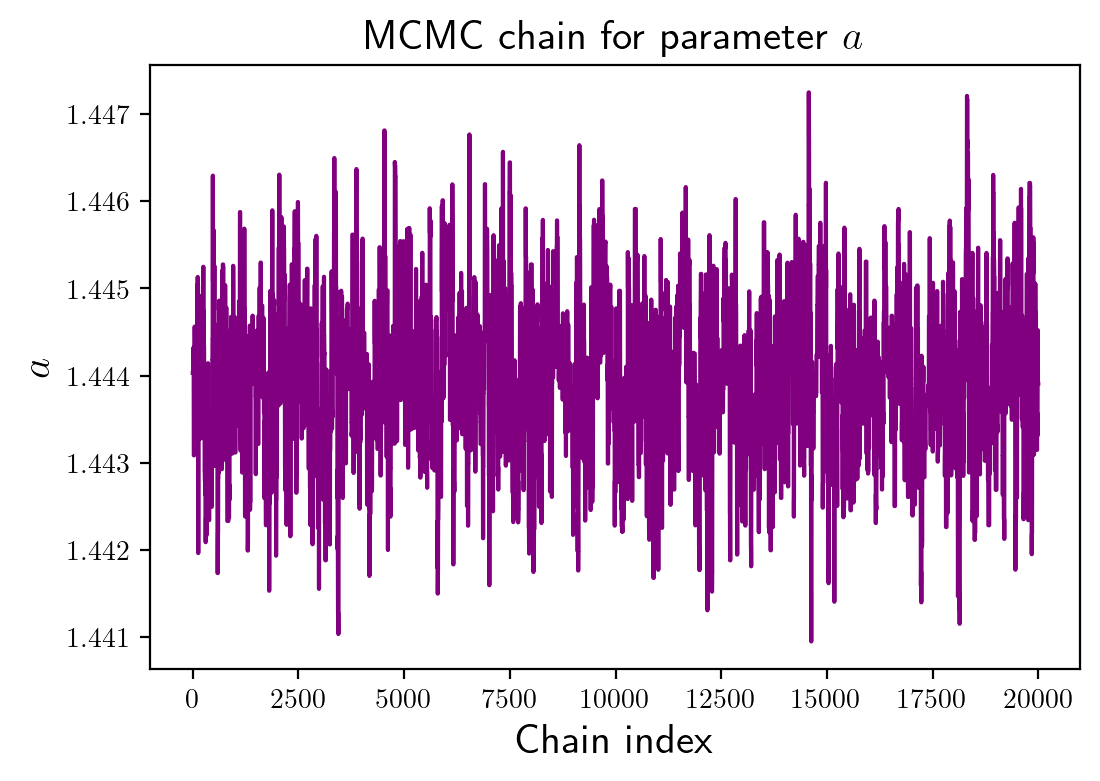

In [18]:
plt.plot(chain[:,0],color='purple')
plt.xlabel('Chain index',fontsize=15)
plt.ylabel('$a$',fontsize=15)
plt.title('MCMC chain for parameter $a$',fontsize=15)

Text(0.5, 1.0, 'MCMC chain for parameter $b$')

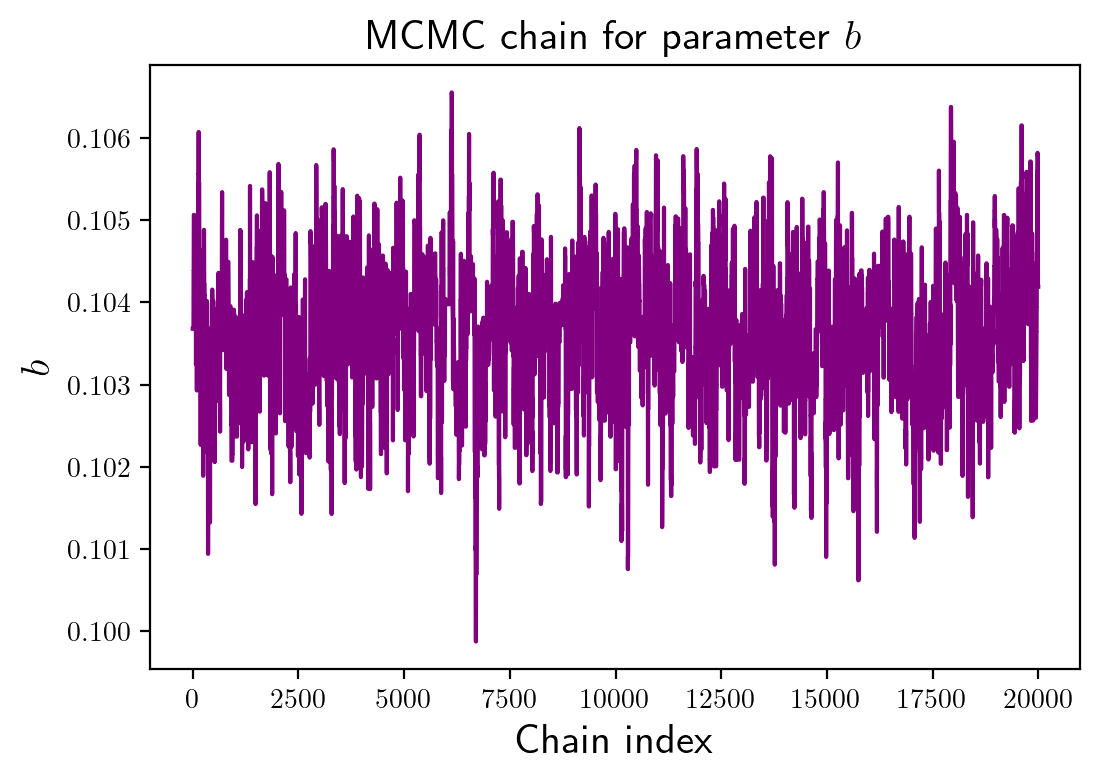

In [19]:
plt.plot(chain[:,1],color='purple')
plt.xlabel('Chain index',fontsize=15)
plt.ylabel('$b$',fontsize=15)
plt.title('MCMC chain for parameter $b$',fontsize=15)

Text(0.5, 1.0, 'MCMC chain for parameter $c$')

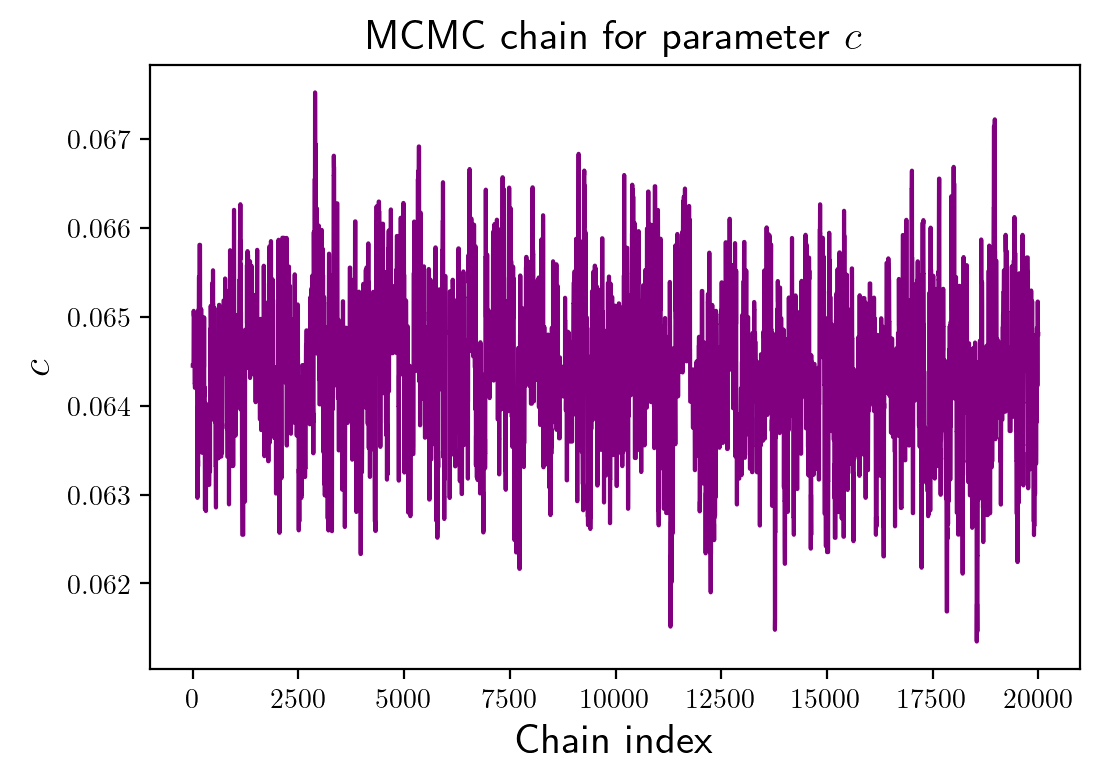

In [20]:
plt.plot(chain[:,2],color='purple')
plt.xlabel('Chain index',fontsize=15)
plt.ylabel('$c$',fontsize=15)
plt.title('MCMC chain for parameter $c$',fontsize=15)

Text(0.5, 1.0, 'MCMC chain for parameter $w$')

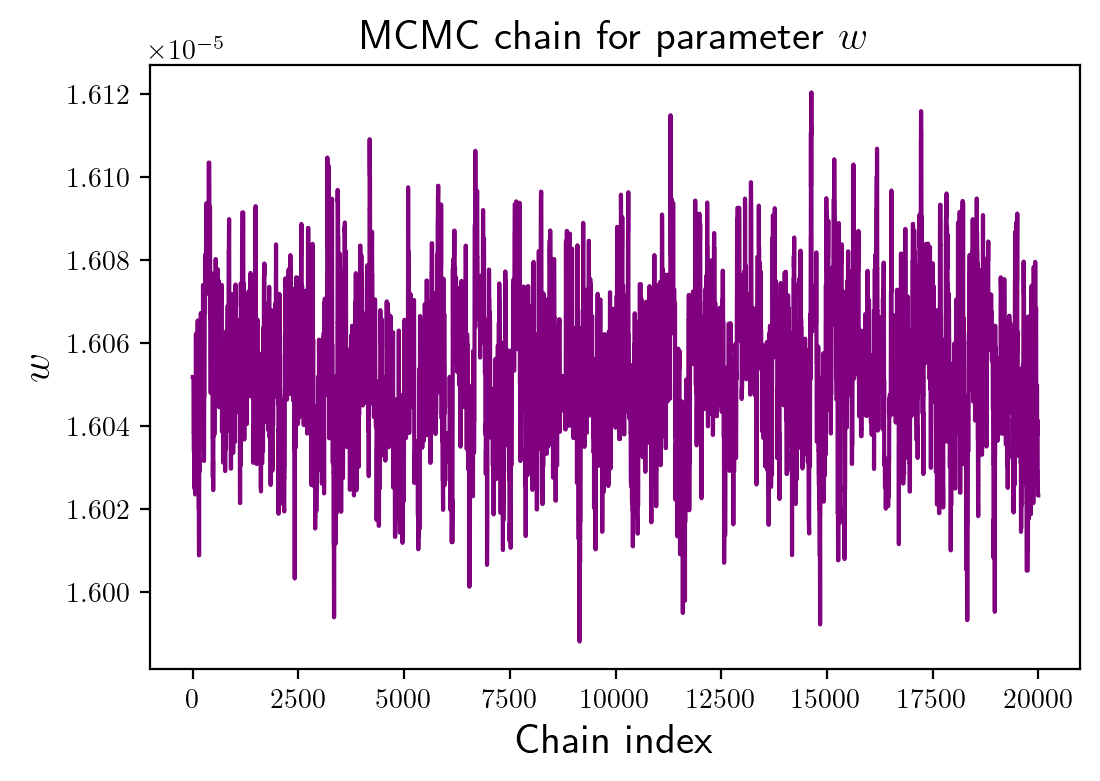

In [21]:
plt.plot(chain[:,3],color='purple')
plt.xlabel('Chain index',fontsize=15)
plt.ylabel('$w$',fontsize=15)
plt.title('MCMC chain for parameter $w$',fontsize=15)

Text(0.5, 1.0, 'MCMC chain for parameter $t_0$')

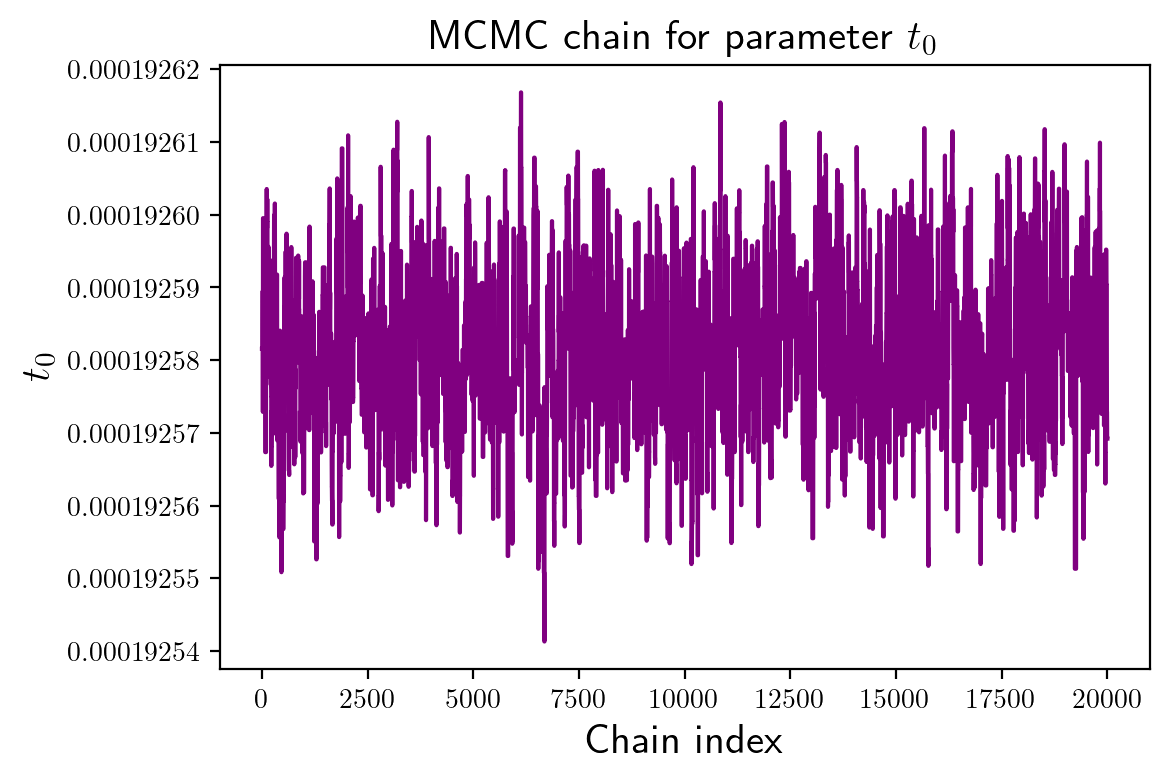

In [22]:
plt.plot(chain[:,4],color='purple')
plt.xlabel('Chain index',fontsize=15)
plt.ylabel('$t_0$',fontsize=15)
plt.title('MCMC chain for parameter $t_0$',fontsize=15)

Text(0.5, 1.0, 'MCMC chain for parameter $dx$')

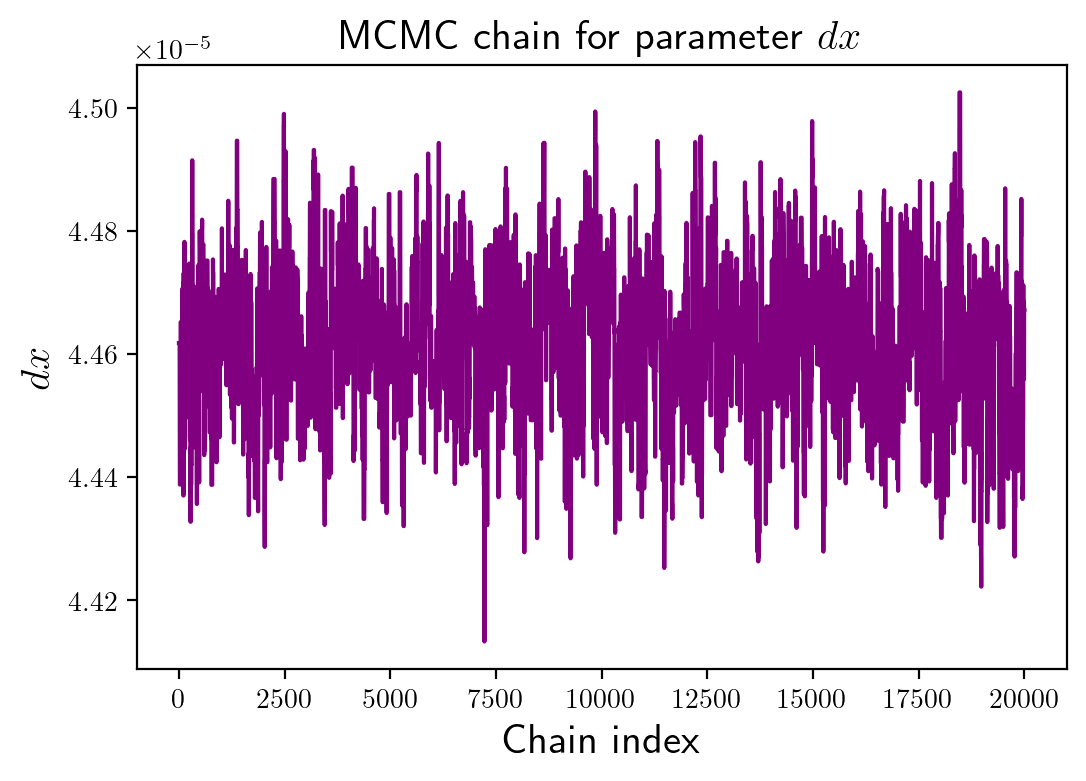

In [23]:
plt.plot(chain[:,5],color='purple')
plt.xlabel('Chain index',fontsize=15)
plt.ylabel('$dx$',fontsize=15)
plt.title('MCMC chain for parameter $dx$',fontsize=15)

All the chains seems to have converged (no apparent structure on the scale of the entire chain). We now get new fit parameters and errors by finding the mean and standard deviation of the samples from the chain. We exclude the first 1000 samples to make sure all samples considered are at equilibrium.

In [24]:
# Compute means and standard deviations
a = np.mean(chain[:,0])
e_a = np.std(chain[:,0])
b = np.mean(chain[:,1])
e_b = np.std(chain[:,1])
c = np.mean(chain[:,2])
e_c = np.std(chain[:,2])
w = np.mean(chain[:,3])
e_w = np.std(chain[:,3])
t0 = np.mean(chain[:,4])
e_t0 = np.std(chain[:,4])
dx = np.mean(chain[:,5])
e_dx = np.std(chain[:,5])

# Print parameters and errors
print(a,e_a)
print(b,e_b)
print(c,e_c)
print(w,e_w)
print(t0,e_t0)
print(dx,e_dx)

1.4439876631631017 0.0008877283345928056
0.10365007719574865 0.0008463426776811536
0.0644275904191956 0.0008469907912247963
1.605309425954202e-05 1.842802130411738e-08
0.00019258138214179143 1.1025804566358452e-08
4.461693499581156e-05 1.1817129959678971e-07


So the parameters we get with the MCMC are
\begin{align}
    a &= 1.44 \pm 8.88\text{x}10^{-4}\\
    b &= 1.04\text{x}10^{-1} \pm 8.76\text{x}10^{-4}\\
    c &= 6.45\text{x}10^{-2} \pm 8.33\text{x}10^{-4}\\
    w &= 1.61\text{x}10^{-5} \pm 1.80\text{x}10^{-8}\\
    t_0 &= 1.93\text{x}10^{-4} \pm 1.10\text{x}10^{-8}\\
    dx &= 4.46\text{x}10^{-5} \pm 1.23\text{x}10^{-7}
\end{align}
The uncertainties are slightly different but not by much. Some went up and some went down.

## h)

The width of the cavity is then given by
\begin{align}
    \text{width} = \Big(\frac{dx}{w}\Big)9 \text{ GHz}
\end{align}
which I compute below


In [25]:
width = dx/w*9
e_width = width*(e_w/w)
print(width,e_width)

25.014019631985892 0.028714643994932676


So the width of the vacity resonance is
\begin{align}
    \text{width} = (25.01 \pm 0.03) \text{ GHz}
\end{align}